In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

from datetime import timedelta, date
import time
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../../../filecoin-mecha-twin/')

from mechafil.data import get_historical_network_stats, \
    get_sector_expiration_stats, \
    query_starboard_supply_stats, \
    get_day_renewed_qa_power_stats, \
    query_starboard_sector_expirations
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

In [3]:
font = {'size' : 10}

matplotlib.rc('font', **font)

## 1. Parameters and other variables

In [4]:
# Units
GIGA = 2**30
MEGA = 1_000_100
EXA = 10**18
EXBI_TO_BYTES = 2**60
BYTES_TO_EXBI = 1./EXBI_TO_BYTES
PEBI_TO_BYTES = 2**50
BYTES_TO_PEBI = 1./PEBI_TO_BYTES
PEBI_TO_EXBI = 1./1024.
EPOCH_PER_DAY = 2880

# constants defined in the filecoin spec: spec.filecoin.io
LAMBDA = np.log(2) / (
    6.0 * 365 * EPOCH_PER_DAY
) 
SIMPLE_ALLOC = 0.3 * 1.1 * 10**9
BASELINE_ALLOC = 0.7 * 1.1 * 10**9
BASELINE_B0 = 2.88888888 * EXBI_TO_BYTES  # initial storage
EPOCH_PER_DAY = 2880
BASELINE_R = np.log(2) / (EPOCH_PER_DAY*365) # 1_051_200 in eopchs

In [5]:
# TODO: make these distributions and simulate MC
renewal_rate= 0.4
rb_onboard_power = 10.0
fil_plus_rate = 0.08

duration = 360

In [6]:
mainnet_start = datetime.date(2020, 10, 15)

start_date = datetime.date(2021, 3, 15) 
start_day = (start_date - mainnet_start).days

current_date = datetime.date(2021, 11, 3) 
current_day = (current_date - mainnet_start).days

# forecasting length in days
# forecast_lenght = 365
# forecast_lenght = 500
forecast_lenght = 365
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

In [7]:
current_day_stats = fil_stats_df[fil_stats_df['date'] >= pd.to_datetime(current_date, utc="UTC")]
current_day_stats

,circulating_fil,mined_fil,vested_fil,locked_fil,burnt_fil,date,total_raw_power_eib,total_qa_power_eib,day_onboarded_rb_power_pib,day_onboarded_qa_power_pib,day_renewed_qa_power_pib
232,1.924457e+08,1.244253e+08,2.010689e+08,1.214736e+08,2.864154e+07,2021-11-03,13.113957,13.131008,35.067993,34.8083,1.912994


In [8]:
res = get_sector_expiration_stats(start_date, current_date,end_date)

rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]

In [9]:
rb_power_zero = current_day_stats["total_raw_power_eib"].values[0] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"].values[0] * 1024.0

rb_power_df, qa_power_df = forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

In [10]:
# Get last baseline value from Starboard API
url = f"https://observable-api.starboard.ventures/api/v1/observable/network-storage-capacity/new_baseline_power"
r = requests.get(url)
baseline_power_df = pd.DataFrame(r.json()["data"])
baseline_power_df["date"] = pd.to_datetime(baseline_power_df["stat_date"])
    
init_baseline_bytes = int(baseline_power_df[baseline_power_df["date"] >= pd.to_datetime(current_date, utc="UTC")].iloc[0,1])
init_baseline = init_baseline_bytes*BYTES_TO_EXBI
# init-baseline (b0) just pulls the baseline power and we grab it for the date for which 
# we start the simulation. We could have just used the function and computed it, but in that case
# we need to project out the # of days since the starting point to compute the baseline for that point.

# Baseline function
baseline_growth = float(np.log(2)/365.0)
num_days = end_date-current_date
num_days = num_days.days
baseline_df = pd.DataFrame({
    "index": np.arange(num_days).astype("float"),
    "date": pd.date_range(start=current_date, freq="d", periods=num_days),
})

# Notice that this is in terms of *days*. If you look at the filecoin spec, baseline growth is in units of seconds.
# however, if the time index is in terms of days, and baseline growth is converted to units of days (/365 rather than /[365*24*60*60])
# then it works out to be the same.
baseline_df["baseline_power_eib"] =  init_baseline * np.exp(baseline_growth*baseline_df["index"])
baseline_df = baseline_df[["date", "baseline_power_eib"]]

In [11]:
power_df = baseline_df[['date', 'baseline_power_eib']]
power_df['rb_power_eib'] = rb_power_df['total_raw_power_eib']
power_df['qa_power_eib'] = qa_power_df['total_qa_power_eib']

In [12]:
today_date = datetime.date.today() - datetime.timedelta(days=3)  # some of the data comes in a bit slower ... 
today_day = (today_date - mainnet_start).days

end_day = today_day + forecast_lenght
end_date = today_date + datetime.timedelta(days=forecast_lenght)

fil_stats_df_full = get_historical_network_stats(start_date,today_date,end_date)

<IPython.core.display.Javascript object>


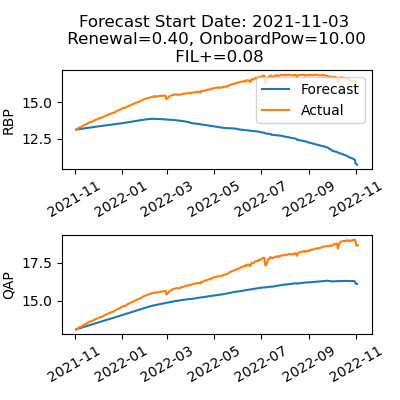

In [13]:
fig = plt.figure(figsize=(4,4))
plt.subplot(2,1,1)

forecast_start = current_date
forecast_end = forecast_start + datetime.timedelta(days=forecast_lenght)

fil_stats_df_subset = fil_stats_df_full[(fil_stats_df_full['date'] >= forecast_start) & ((fil_stats_df_full['date'] <= forecast_end))]

plt.plot(power_df['date'], power_df['rb_power_eib'], label='Forecast')
plt.plot(fil_stats_df_subset['date'], fil_stats_df_subset['total_raw_power_eib'], label='Actual')
plt.xticks(rotation=30)
plt.ylabel('RBP')
plt.title('Forecast Start Date: %s \n Renewal=%0.02f, OnboardPow=%0.02f \n FIL+=%0.02f' % 
          (current_date,renewal_rate,rb_onboard_power,fil_plus_rate))
plt.legend()

plt.subplot(2,1,2)
plt.plot(power_df['date'], power_df['qa_power_eib'], label='Forecast from 2021-03-16')
plt.plot(fil_stats_df_subset['date'], fil_stats_df_subset['total_qa_power_eib'], label='Actual')
plt.xticks(rotation=30)
plt.ylabel('QAP')

fig.tight_layout()